In [ ]:
import numpy as np
import pandas as pd
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [10]:
data_root = '/home/jupyter/datasphere/project/project'
print(os.listdir(data_root))

['.ipynb_checkpoints', 'train']


# Разделение датасета на валидационную и тренировочную выборки.

In [15]:
import os
import shutil

# Путь к папке с изображениями
src_dir = '/home/jupyter/datasphere/project/images'

# Папки назначения для train и val
train_dir = '/home/jupyter/datasphere/project/smokers_die_young/train'
val_dir = '/home/jupyter/datasphere/project/smokers_die_young/val'

# Создаем директории train и val для классов, если они не существуют
for class_name in ['smoking', 'notsmoking']:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

# Проход по папкам smoking и not smoking
for class_name in ['smoking', 'notsmoking']:
    class_path = os.path.join(src_dir, class_name)
    images = sorted(os.listdir(class_path))  # Сортируем для предсказуемого поведения
    
    for idx, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        
        # Проверка, является ли текущий элемент файлом
        if os.path.isfile(img_path):
            # Каждую пятую фотографию кладем в папку val, остальные в train
            if (idx + 1) % 5 == 0:
                dest_dir = os.path.join(val_dir, class_name)
            else:
                dest_dir = os.path.join(train_dir, class_name)
            
            # Копируем файл
            shutil.copy(img_path, os.path.join(dest_dir, img_name))

print("Распределение изображений завершено!")


Распределение изображений завершено!


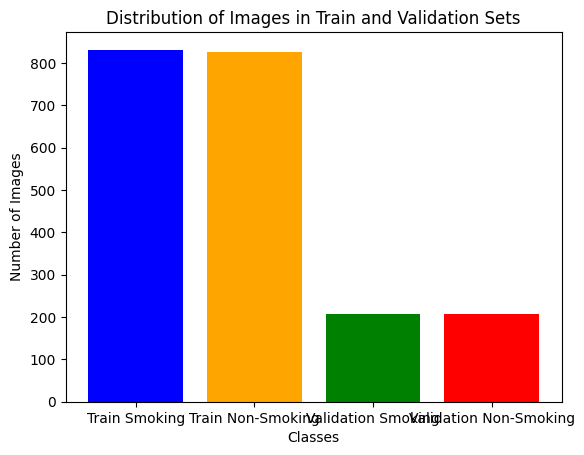

In [17]:
import matplotlib.pyplot as plt

def print_data():
    train_smoking = len(os.listdir('/home/jupyter/datasphere/project/smokers_die_young/train/smoking'))
    train_nonsmoking = len(os.listdir('/home/jupyter/datasphere/project/smokers_die_young/train/notsmoking'))
    val_smoking = len(os.listdir('/home/jupyter/datasphere/project/smokers_die_young/val/smoking'))
    val_nonsmoking = len(os.listdir('/home/jupyter/datasphere/project/smokers_die_young/val/notsmoking'))
    labels = ['Train Smoking', 'Train Non-Smoking', 'Validation Smoking', 'Validation Non-Smoking']
    values = [train_smoking, train_nonsmoking, val_smoking, val_nonsmoking]
    plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title('Distribution of Images in Train and Validation Sets')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()
print_data()

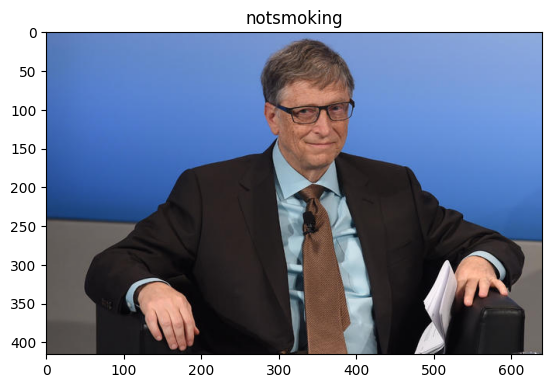

In [26]:
from PIL import Image
import random

def show_random_image(image_folder):
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    random_image_path = random.choice(image_paths)
    folder_name = os.path.basename(os.path.dirname(random_image_path))
    image = Image.open(random_image_path)
    plt.imshow(image)
    plt.title(folder_name)
    plt.show()
    plt.pause(0.001)
show_random_image('/home/jupyter/datasphere/project/smokers_die_young/val/notsmoking')

# Предобработка датасета: применение аугментаций для датасета соревнования и open source.

In [16]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms.functional import adjust_brightness
from PIL import Image
image_folders_train = ["/home/jupyter/datasphere/project/train/smoking", "/home/jupyter/datasphere/project/train/notsmoking"]

# Аугментации к open source датасету
train_transforms_data_all = [
    transforms.Compose([
        transforms.RandomRotation(60),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.RandomGrayscale(p=1),
        transforms.RandomOrder([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ]),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.RandomInvert(),
        transforms.ToTensor(),
]), 
     transforms.Compose([
        transforms.GaussianBlur(kernel_size=3),  # Применение гауссовского размытия
        transforms.ToTensor(),
    ]),
]
#Аугментации к датасету соревнования

# Определение функции для уменьшения яркости изображения
def reduce_brightness(image, factor):
    return adjust_brightness(image, factor)

train_transforms_dataset_source = [
    transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.RandomGrayscale(p=1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.Lambda(lambda x: reduce_brightness(x, 0.5)),  # Уменьшение яркости на 0.5
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.CenterCrop(100),
        transforms.Lambda(lambda x: reduce_brightness(x, 0.3)),  # Уменьшение яркости на 0.3,
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
]

augment_number = 25

for image_folder in image_folders_train:
    for index_image, filename in enumerate(os.listdir(image_folder)):
        # Получение пути к текущему изображению
        image_path = os.path.join(image_folder, filename)

        if not filename.startswith('data_') and index_image % augment_number == 0:
            # Применение аугментаций
            for index, transform in enumerate(train_transforms_data_all):
                augmented_image = transform(Image.open(image_path))

                # Получение имени файла без расширения
                name, ext = os.path.splitext(filename)

                # Формирование имени аугментированного файла
                augmented_filename = f"{name}_{index}_augmented{ext}"

                # Сохранение аугментированного изображения
                output_path = os.path.join(image_folder, augmented_filename)
                save_image(augmented_image, output_path)
        elif filename.startswith('data_'):
            for index, transform in enumerate(train_transforms_dataset_source):
                augmented_image = transform(Image.open(image_path))

                name, ext = os.path.splitext(filename)

                augmented_filename = f"{name}_{index}_augmented{ext}"

                output_path = os.path.join(image_folder, augmented_filename)
                save_image(augmented_image, output_path)

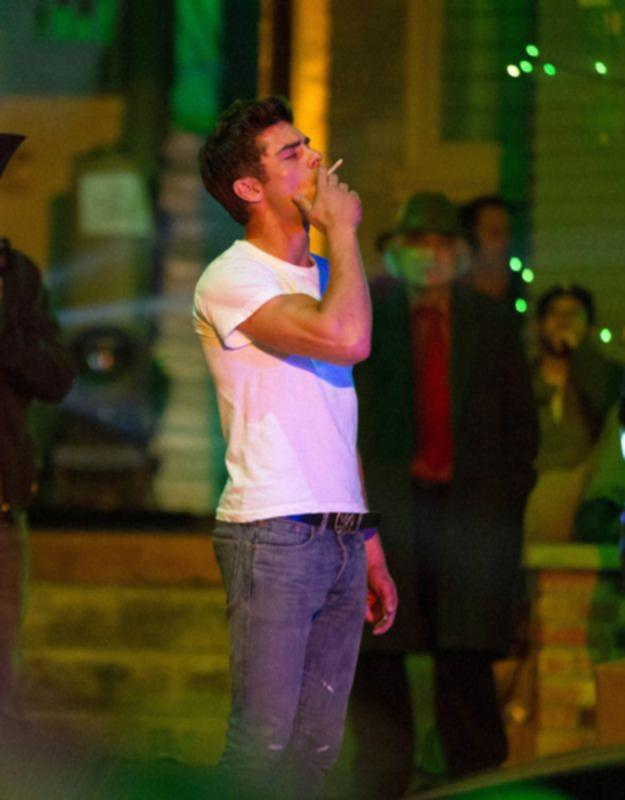

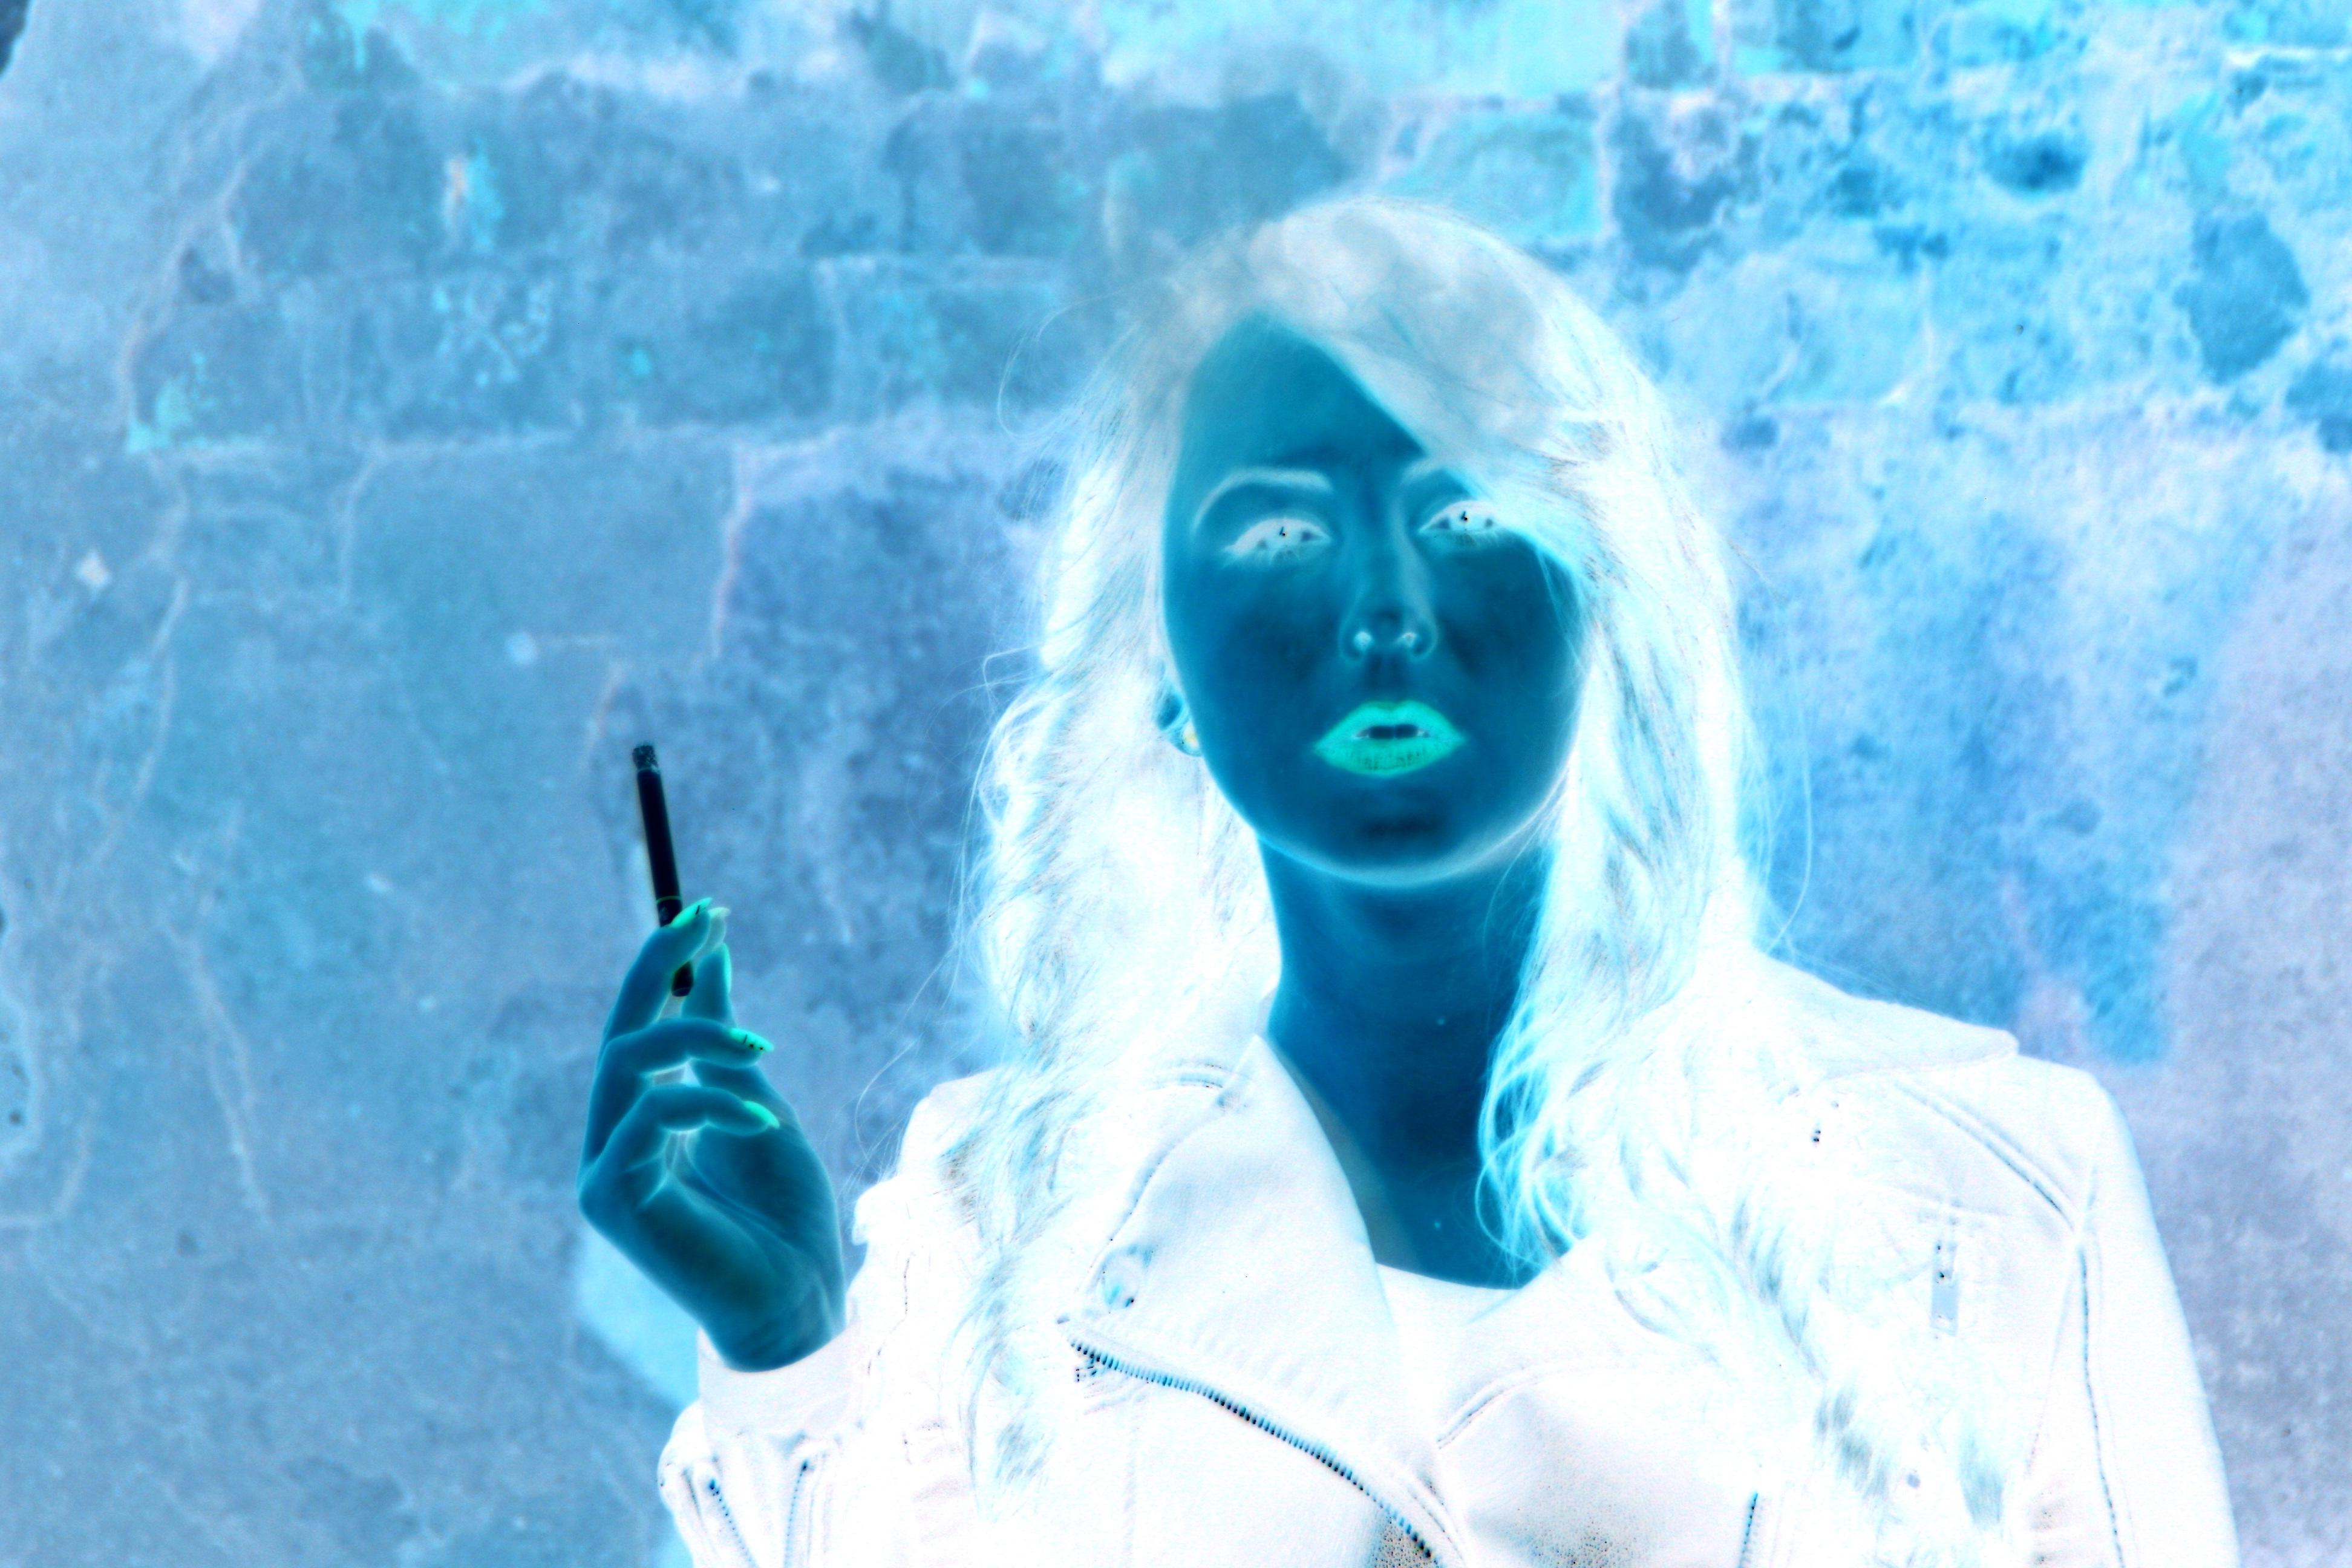

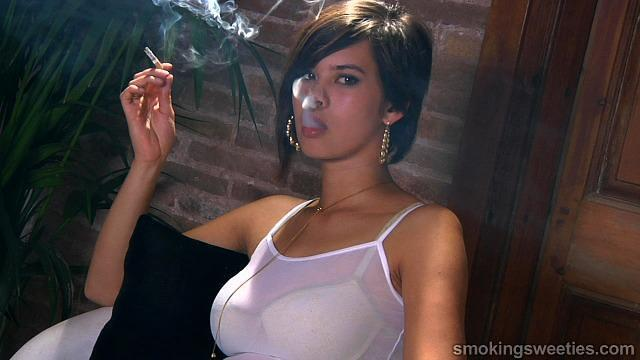

In [7]:
from IPython.display import display, Image
print_image = 3
total  = 0
image_folger = '/kaggle/working/train/smoking'
for filename in os.listdir(image_folger):
    if '_augmented' in filename:
        if total == print_image:
            break
        total+=1
        image_path = os.path.join(image_folger, filename)
        display(Image(filename=image_path, height=400))
        print("\n")

# Обучение нейросети.

In [18]:
%pip -q install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon Processor (Icelake))
Setup complete ✅ (4 CPUs, 31.3 GB RAM, 63.1/98.3 GB disk)


In [22]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1]:
%pip -q install wandb


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
pip -q install ultralytics


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from ultralytics import YOLO

# Загрузка модели YOLOv8 для классификации
model = YOLO('yolov8n-cls.pt')  # Загрузить предварительно обученную модель

# Запуск тренировки
model.train(data='/home/jupyter/datasphere/project/Images/images', epochs=10)

# Использование mlflow для логирования параметров и весов модели

In [5]:
import mlflow

# Завершение текущего запуска, если он активен
if mlflow.active_run() is not None:
    mlflow.end_run()


In [7]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import logging

In [4]:
%pip -q install mlflow

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
# Игнорирование предупреждений + установка трекинга на публичный ip виртуалки
import mlflow
import warnings
warnings.filterwarnings("ignore")
mlflow.set_tracking_uri("http://89.169.154.235:8000/")
print(mlflow.get_tracking_uri())


http://89.169.154.235:8000/


In [5]:
mlflow.set_experiment("new_experiment_2")

<Experiment: artifact_location='s3://mlflow-bucket1/artifacts/5', creation_time=1727985295134, experiment_id='5', last_update_time=1727985295134, lifecycle_stage='active', name='new_experiment_2', tags={}>

In [8]:
import mlflow
from ultralytics import YOLO
import os

# Инициализация вложенной сессии MLflow
with mlflow.start_run() as run:
    # Логирование гиперпараметров
    mlflow.log_param("model", "yolov8l-cls.pt")
    mlflow.log_param("epochs", 5)

    # Загрузка модели YOLOv8 для классификации
    model = YOLO('yolov8l-cls.pt')  # Загрузить предварительно обученную модель

    # Запуск тренировки с логированием метрик
    results = model.train(data='/home/jupyter/datasphere/project/smokers_die_young', epochs=5)
    print(results)
    # Логирование метрик
    mlflow.log_metric("accuracy", results.top1)
    mlflow.log_metric("fitness", results.top5)

    # Логирование модели (сохранение весов)
    # Текущий путь к 'best.pt'
    best_weights_path = os.path.join(results.save_dir, 'weights/best.pt')

# Добавляем в начало '/home/jupyter/datasphere/project'
    full_best_weights_path = os.path.join('/home/jupyter/datasphere/project', best_weights_path)
    mlflow.log_artifact(full_best_weights_path)


100%|██████████| 71.7M/71.7M [00:04<00:00, 17.7MB/s]


Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon Processor (Icelake))
engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=/home/jupyter/datasphere/project/smokers_die_young, epochs=5, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train31, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /home/jupyter/work/resources/smokers_die_young/train... 1655 images, 2 corrupt: 100%|██████████| 1655/1655 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/train/notsmoking/251.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/train/notsmoking/754.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/train/notsmoking/811.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/train/notsmoking/911.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'webp', 'tif', 'jpg', 'jpeg', 'png', 'tiff', 'pfm', 'dng', 'mpo', 'bmp'}
videos: {'gif', 'm4v', 'asf', 'mov', 'mp4', 'wmv', 'webm', 'avi', 'mkv', 'mpg', 'ts', 'mpeg'}
train: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/train/smoking/214.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/train/smoking/23.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/jupyter/work/resources


val: Scanning /home/jupyter/work/resources/smokers_die_young/val... 412 images, 1 corrupt: 100%|██████████| 412/412 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/val/notsmoking/351.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/val/notsmoking/44.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/val/notsmoking/814.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/val/smoking/16.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'webp', 'tif', 'jpg', 'jpeg', 'png', 'tiff', 'pfm', 'dng', 'mpo', 'bmp'}
videos: {'gif', 'm4v', 'asf', 'mov', 'mp4', 'wmv', 'webm', 'avi', 'mkv', 'mpg', 'ts', 'mpeg'}
val: WARNING ⚠️ /home/jupyter/work/resources/smokers_die_young/val/smoking/231.jpg: corrupt JPEG restored and saved
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.

TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train31
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.67s/it]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.67s/it]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.68s/it]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.66s/it]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.69s/it]

                   all      0.951          1



5 epochs completed in 0.865 hours.
Optimizer stripped from runs/classify/train31/weights/last.pt, 72.6MB
Optimizer stripped from runs/classify/train31/weights/best.pt, 72.6MB

Validating runs/classify/train31/weights/best.pt...
Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon Processor (Icelake))
YOLOv8l-cls summary (fused): 133 layers, 36,187,138 parameters, 0 gradients, 98.7 GFLOPs
train: /home/jupyter/work/resources/smokers_die_young/train... found 1657 images in 2 classes ✅ 
val: /home/jupyter/work/resources/smokers_die_young/val... found 413 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


                   all      0.951          1
Speed: 0.0ms preprocess, 87.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train31
Results saved to runs/classify/train31


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▇█▅▁
wandb:                  lr/pg1 ▃▇█▅▁
wandb:                  lr/pg2 ▃▇█▅▁
wandb:   metrics/accuracy_top1 ▁▅▅▆█
wandb:   metrics/accuracy_top5 ▁▁▁▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:              train/loss █▃▂▁▁
wandb:                val/loss █▄▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00015
wandb:                  lr/pg1 0.00015
wandb:                  lr/pg2 0.00015
wandb:   metrics/accuracy_top1 0.95146
wandb:   metrics/accuracy_top5 1
wandb:            model/GFLOPs 99.125
wandb:        model/parameters 36202306
wandb: model/speed_PyTorch(ms) 88.657
wandb:              train/loss 0.13448
wandb:                val/loss 0.36734
wandb: 
wandb: 🚀 View run train30 at: https://wandb.ai/iliiich/YOLOv8/runs/8h7227pq
wandb: ⭐️ View project at: https

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f54b0746bf0>
curves: []
curves_results: []
fitness: 0.9757281541824341
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9514563083648682, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9757281541824341}
save_dir: PosixPath('runs/classify/train31')
speed: {'preprocess': 0.0005526450073834761, 'inference': 87.28345389505036, 'loss': 7.349310569392824e-05, 'postprocess': 6.654887523465943e-05}
task: 'classify'
top1: 0.9514563083648682
top5: 1.0


2024/10/03 21:01:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-stag-529 at: http://89.169.154.235:8000/#/experiments/5/runs/bcfb0e222274421381bd9fa5018274cd.
2024/10/03 21:01:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://89.169.154.235:8000/#/experiments/5.


## Predict на произвольной фотографии

In [30]:
from ultralytics import YOLO

# Загрузка модели с лучшими весами
model = YOLO('/home/jupyter/datasphere/project/runs/classify/train/weights/best.pt')  # Загрузить модель с лучшими весами

# Путь к папке с тестовыми данными
test_data = '/home/jupyter/datasphere/project/f9e727b0-c3e7-4658-b50a-22d70e113a92.jpeg'

# Запуск предсказаний
save_dir = '/home/jupyter/datasphere/project'

# Запуск предсказаний с сохранением результата
results = model.predict(source=test_data, save=True, save_dir=save_dir)

# Печать результатов
for result in results:
    print(result)


image 1/1 /home/jupyter/datasphere/project/f9e727b0-c3e7-4658-b50a-22d70e113a92.jpeg: 224x224 smoking 0.90, notsmoking 0.10, 10.3ms
Speed: 4.6ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs/classify/predict
ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'notsmoking', 1: 'smoking'}
obb: None
orig_img: array([[[177, 190, 192],
        [242, 255, 255],
        [233, 246, 248],
        ...,
        [230, 214, 202],
        [228, 213, 204],
        [228, 213, 204]],

       [[177, 190, 192],
        [242, 255, 255],
        [233, 246, 248],
        ...,
        [230, 214, 202],
        [230, 214, 202],
        [230, 214, 202]],

       [[176, 189, 191],
        [241, 254, 255],
        [233, 246, 248],
        ...,
        [233, 214, 201],
        [233, 214, 201],
        [235, 213, 201]],

       ...,

       [[ 95,  65, 214],
        [129,  97, 255],
        [104, 

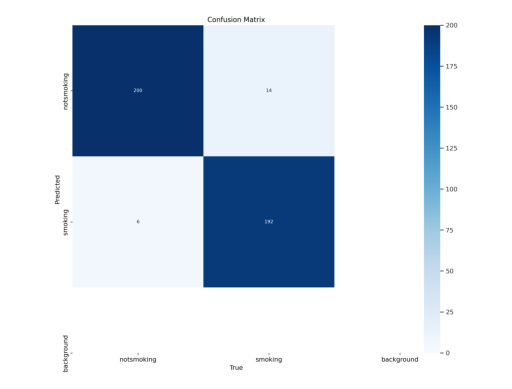

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Открываем изображение
image = Image.open('/home/jupyter/datasphere/project/runs/classify/train31/confusion_matrix.png')

# Отображаем изображение в Jupyter Notebook
plt.imshow(image)
plt.axis('off')  # Отключаем оси
plt.show()


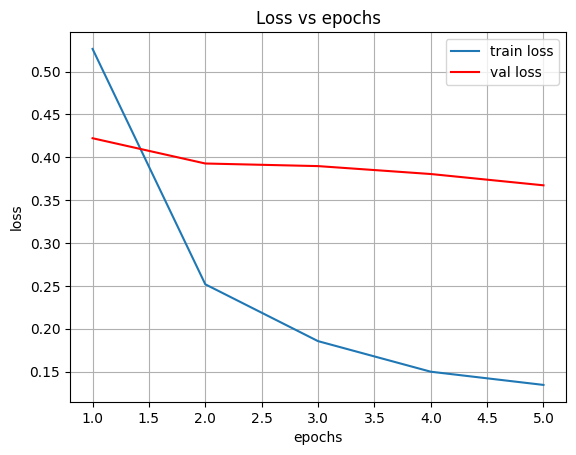

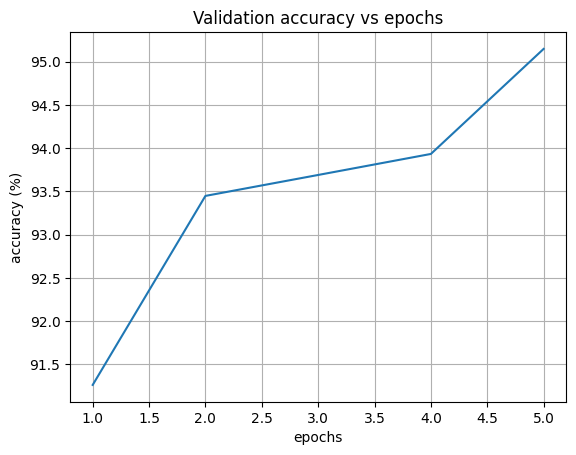

In [16]:
import pandas as pd

results_path = '/home/jupyter/datasphere/project/runs/classify/train31/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

# Детекция человека.

In [19]:
%pip install -q --no-warn-script-location git+https://github.com/Deci-AI/super-gradients.git@stable


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [20]:
import pathlib
from super_gradients.training import models
from super_gradients.common.object_names import Models

[2024-10-03 21:35:20] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/jupyter/sg_logs/console.log


[2024-10-03 21:35:28] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose")
model.to(device)

[2024-10-03 21:42:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


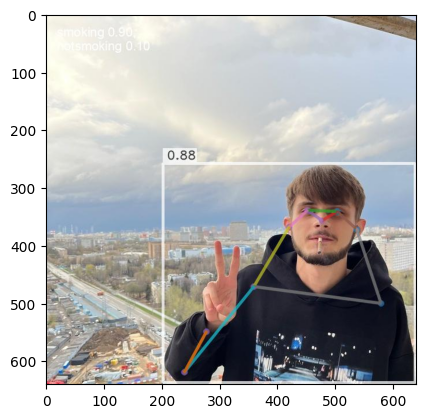

In [33]:
output = model.predict('/home/jupyter/datasphere/project/runs/classify/predict/f9e727b0-c3e7-4658-b50a-22d70e113a92.jpeg', conf=confidence)

# Сохраните результат с правильным расширением
output.save('/home/jupyter/datasphere/pred_pose/output_image.jpg') 

# Открываем изображение
image = Image.open('/home/jupyter/datasphere/pred_pose/output_image.jpg')

# Отображаем изображение с помощью matplotlib
plt.imshow(image)